In [1]:
import numpy as np
import h5py
import sys
sys.path.append('/Users/eframe/dmi/src')
import calibrate as calib
import eventAnalysis as ea
import tables
import matplotlib.pyplot as plt
import codedAperture as ca
import glob
import tables
from scipy import ndimage
import more_itertools as mit
import pandas as pd
from scipy.optimize import curve_fit
from matplotlib.font_manager import FontProperties
from matplotlib import ticker

In [2]:
def gauss(x, h, mu, sig):
    """ Gaussian function
    """
    return h*np.exp(-0.5*((x-mu)/sig)**2)

In [3]:
# Loading Image Data
%matplotlib inline
m = 2
f1 = tables.open_file('/Users/eframe/Downloads/eventbinning/co57_m2_on_5_v2.h5', 'r')
f2 = tables.open_file('/Users/eframe/Downloads/eventbinning/co57_m2_on_all.h5', 'r')
f3 = tables.open_file('/Users/eframe/Downloads/eventbinning/co57_m2_off_5_v2.h5', 'r')
f4 = tables.open_file('/Users/eframe/Downloads/eventbinning/co57_m2_off_all.h5', 'r')
src1 = f1.root.image.read()
src2 = f2.root.image.read()
src3 = f3.root.image.read()
src4 = f4.root.image.read()
f1.close()
f2.close()
f3.close()
f4.close()

In [4]:
wd = 2
wm = 2
res = 1 / ( m - 1 ) * np.sqrt( ( m * wm ) ** 2 + wd ** 2 )
sig = res / 2.355
print(res, sig)

4.47213595499958 1.8989961592354903


In [5]:
# Reshaping Image Data into 3D Image
binSize = 2
sourceX, sourceY, sourceZ = np.mgrid[ -99:101:binSize, -49:51:binSize, -49:51:binSize ]
vals1 = ( src1.reshape( sourceX.shape ) / max(src1) )[40:-10]
vals2 = ( src2.reshape( sourceX.shape ) / max(src2) )[40:-10]
vals3 = ( src3.reshape( sourceX.shape ) / max(src3) )[40:-10]
vals4 = ( src4.reshape( sourceX.shape ) / max(src4) )[40:-10]
sourceX, sourceY, sourceZ = np.mgrid[ -19:81:binSize, -49:51:binSize, -49:51:binSize ]
sourcePixels = np.array([sourceX.flatten(), sourceY.flatten(), sourceZ.flatten()]).T

In [6]:
intensity = np.copy(vals1.flatten())
vals1.shape

(50, 50, 50)

18


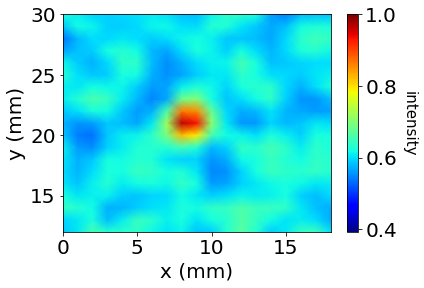

In [7]:
# Plotting 2D projections of Image
%matplotlib inline
vals = vals1.copy()
vals[vals<0]=0
depth = np.array( sourceZ[:,0][0] )
a, b = min(vals.flatten()), max(vals.flatten())
for i in np.arange( 18,19 ):
    fig, ax = plt.subplots()
    grid = vals[ :, :, i] 
#     a, b = min(grid.flatten()), max(grid.flatten())
    im = ax.pcolormesh( grid.T, vmin=a, vmax=b, cmap='jet', shading = 'gouraud' ) 
    ax.set_xlabel( 'x (mm)', fontsize = 20 )
    ax.set_ylabel( 'y (mm)', fontsize = 20 )
    ax.set_xlim(0, 18)
    ax.set_ylim(12, 30)
    ax.tick_params( labelsize = 20 )
    cbar = plt.colorbar( im )
    cbar.set_label( label = 'intensity', rotation = 270, fontsize = 15, labelpad = 20 )
    cbar.ax.tick_params( labelsize = 20 )
    print(i)
    plt.show()

/Users/eframe/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


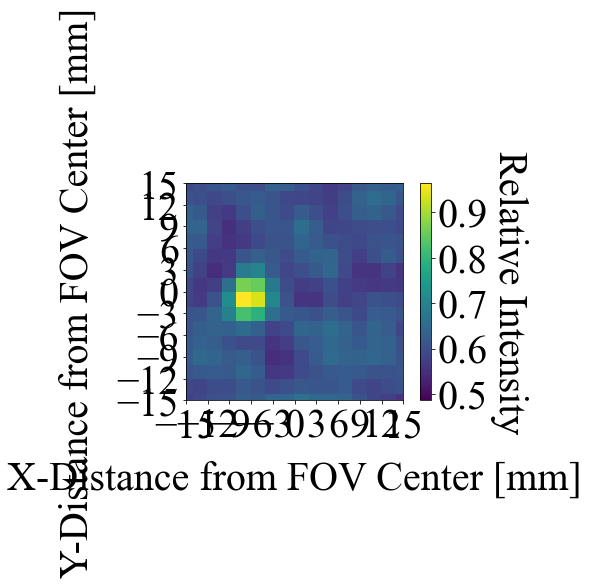

In [8]:
%matplotlib inline
vals = vals1.copy()
vals[vals<0]=0
depth = np.array( sourceZ[:,0][0] )
a, b = min(vals.flatten()), max(vals.flatten())
sX, sY, = np.mgrid[ -19:81:binSize, -44:56:binSize,  ] # m = 2
sX, sY, = np.mgrid[ -24:76:binSize, -44:56:binSize ] # m = 1.5
# Plotting Detector Response
font = FontProperties()
font.set_name('Times New Roman')
binSize = 2
fig, ax = plt.subplots()
im = ax.pcolormesh(sX, sY, grid)
ax.tick_params(labelsize=150)
ax.set_xlabel('X-Distance from FOV Center [mm]', fontsize=40, fontproperties=font, labelpad=15)
ax.set_ylabel('Y-Distance from FOV Center [mm]', fontsize=40, fontproperties=font, labelpad=20)
ax.set_ylim(-15, 15)
ax.set_xlim(-15, 15)
ax.xaxis.set_ticks(np.arange(-15, 18, 3))
ax.yaxis.set_ticks(np.arange(-15, 18, 3))
ax.set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im)
cbar.set_label(label='Relative Intensity', rotation=270, fontsize=40, fontproperties=font, labelpad=40)
cbar.ax.tick_params(labelsize=40)

tick_locator = ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()

for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in cbar.ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
plt.show()

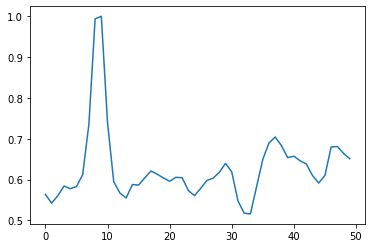

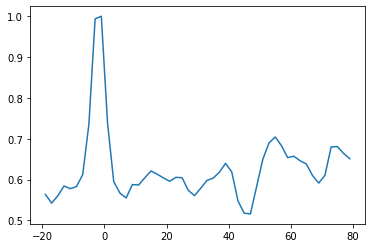

In [11]:
%matplotlib inline

# M=2 Bins = 5mm V2
x1, y1, z1 = 9, 21, 21
x2, y2, z2 = 8, 21, 21
x3, y3, z3 = 36, 21, 22
x4, y4, z4 = 35, 21, 21

# # M=2 Bins = 5mm
# x1, y1, z1 = 8, 21, 23
# x2, y2, z2 = 8, 21, 21
# x3, y3, z3 = 36, 21, 25
# x4, y4, z4 = 35, 21, 21

# # M=2 Bins = 2mm
# x1, y1, z1 = 9, 21, 21
# x2, y2, z2 = 8, 21, 21
# x3, y3, z3 = 36, 21, 22
# x4, y4, z4 = 35, 21, 21

# # M=1.5 Bins = 5mm V2
# x1, y1, z1 = 12, 21, 18
# x2, y2, z2 = 12, 21, 24
# x3, y3, z3 = 40, 22, 16
# x4, y4, z4 = 41, 22, 22

# # M=1.5 Bins = 5mm
# x1, y1, z1 = 12, 21, 24
# x2, y2, z2 = 12, 21, 24
# x3, y3, z3 = 42, 22, 26
# x4, y4, z4 = 41, 22, 22

# # M=1.5 Bins = 2mm
# x1, y1, z1 = 12, 21, 17
# x2, y2, z2 = 12, 21, 24
# x3, y3, z3 = 40, 22, 16
# x4, y4, z4 = 41, 22, 22


x_val1, x_coord1 = vals1[ :, :, z1][:, y1], sourceX[:, :, z1][:, y1]
x_val2, x_coord2 = vals2[ :, :, z2][:, y2], sourceX[:, :, z2][:, y2]
x_val3, x_coord3 = vals3[ :, :, z3][:, y3], sourceX[:, :, z3][:, y3]
x_val4, x_coord4 = vals4[ :, :, z4][:, y4], sourceX[:, :, z4][:, y4]

# x_val1, x_coord1 = vals1[ :, :, z1][x1, :], sourceY[:, :, z1][x1, :]
# x_val2, x_coord2 = vals2[ :, :, z2][x2, :], sourceY[:, :, z2][x2, :]
# x_val3, x_coord3 = vals3[ :, :, z3][x3, :], sourceY[:, :, z3][x3, :]
# x_val4, x_coord4 = vals4[ :, :, z4][x4, :], sourceY[:, :, z4][x4, :]

plt.plot( x_val1, '-', label='on 5' )
# plt.plot( x_val2, '-', label='on all' )
# plt.plot( x_val3, '-', label='off 5' )
# plt.plot( x_val4, '-', label='off all' )
# plt.legend()
plt.show()

plt.plot( x_coord1, x_val1, '-', label='on 2' )
# plt.plot( x_coord2, x_val2, '-', label='on all' )
# plt.plot( x_coord3, x_val3, '-', label='off 2' )
# plt.plot( x_coord4, x_val4, '-', label='off all' )
# plt.legend()
plt.show()

In [12]:
val1, coord1, x_1 = x_val1, x_coord1, x1
val2, coord2, x_2 = x_val2, x_coord2, x2
val3, coord3, x_3 = x_val3, x_coord3, x3
val4, coord4, x_4 = x_val4, x_coord4, x4
baseline1 = ( np.mean( val1[:5] ) + np.mean( val1[20:] ) ) / 2
baseline2 = ( np.mean( val2[:5] ) + np.mean( val2[20:] ) ) / 2
baseline3 = ( np.mean( val3[:30] ) + np.mean( val3[49:] ) ) / 2
baseline4 = ( np.mean( val4[:30] ) + np.mean( val4[49:] ) ) / 2
print(coord1[x_1], coord2[x_2], coord3[x_3], coord3[x_3])
print( baseline1, baseline2, baseline3, baseline4)
# print(coord1[x_1], baseline1)

-1 -3 53 53
0.5922085306066257 0.6052357855760226 0.4738390284989417 0.48449870847429544


In [13]:
popt1, pcov1 = curve_fit( gauss, coord1, 
                       val1 - baseline1, p0 = [ 1, coord1[x_1], sig ] )

popt2, pcov2 = curve_fit( gauss, coord2, 
                       val2 - baseline2, p0 = [ 1, coord2[x_2], sig ] )

popt3, pcov3 = curve_fit( gauss, coord3, 
                       val3 - baseline3, p0 = [ 1, coord3[x_3], sig ] )

popt4, pcov4 = curve_fit( gauss, coord4, 
                       val4 - baseline4, p0 = [ 1, coord2[x_4], sig ] )

gauss_curve1 = gauss( np.arange(min(coord1), max(coord1), 0.1), popt1[0], popt1[1], popt1[2] )
gauss_curve2 = gauss( np.arange(min(coord2), max(coord2), 0.1), popt2[0], popt2[1], popt2[2] )
gauss_curve3 = gauss( np.arange(min(coord3), max(coord3), 0.1), popt3[0], popt3[1], popt3[2] )
gauss_curve4 = gauss( np.arange(min(coord4), max(coord4), 0.1), popt4[0], popt4[1], popt4[2] )

In [14]:
xvalss = np.arange(min(coord1), max(coord1), 0.1)

In [15]:
half = np.max(gauss_curve1) / 2
mask = ( gauss_curve1 >= half )
FWHM = np.abs( xvalss[mask][0] ) + np.abs( xvalss[mask][-1] )
print(FWHM)

4.500000000000064


In [16]:
popt1[2] * 2.355

4.597308681849196

In [17]:
FWHM1 = popt1[2] * 2.355
FWHM2 = popt2[2] * 2.355
FWHM3 = popt3[2] * 2.355
FWHM4 = popt4[2] * 2.355
print(FWHM1, FWHM2, FWHM3, FWHM4 )
diameter = 2
K = np.sqrt(3) / 6
res1 = 2.36 * np.sqrt( (  popt1[2] ) ** 2 - (diameter * K ) ** 2 ) 
res2 = 2.36 * np.sqrt( (  popt2[2] ) ** 2 - (diameter * K ) ** 2 ) 
res3 = 2.36 * np.sqrt( (  popt3[2] ) ** 2 - (diameter * K ) ** 2 ) 
res4 = 2.36 * np.sqrt( (  popt4[2] ) ** 2 - (diameter * K ) ** 2 ) 
print(res1, res2, res3, res4)

4.597308681849196 4.6122455986201985 4.740854942437266 5.395608037608767
4.400972088888945 4.4166392678048885 4.551341758938305 5.232571482269851


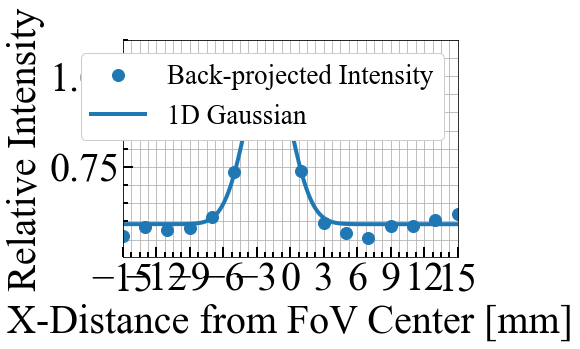

In [18]:
%matplotlib inline
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.set_xlabel('X-Distance from FoV Center [mm]', fontsize=40, fontproperties=font, labelpad=5)
ax.set_ylabel('Relative Intensity', fontsize=40, fontproperties=font)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')

ax.xaxis.set_ticks(np.arange(-19, 18, 4))

ax.plot( coord1, val1, 'o', color='tab:blue', markersize=12, label=r'Back-projected Intensity')
ax.plot(np.arange(min(coord1), max(coord1), 0.1), 
        gauss_curve1 + baseline1, 'tab:blue', linewidth=4, label='1D Gaussian')

ax.legend(prop={"family":"Times New Roman", 'size': 27}, ncol=1, 
          loc='upper right', framealpha=1)
ax.set_ylim(0.501, 1.1)
ax.set_xlim(-15, 15)
ax.xaxis.set_ticks(np.arange(-15, 18, 3))
ax.grid(which='both')
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40) 
plt.show()

In [30]:
%matplotlib qt
font = FontProperties()
font.set_name('Times New Roman')
fig, ax = plt.subplots()
ax.set_xlabel('X-Distance from FoV Center', fontsize=40, fontproperties=font, labelpad=5)
ax.set_ylabel('Relative Intensity', fontsize=40, fontproperties=font)
ax.minorticks_on()
ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
ax.tick_params(which='minor', length=5, width=2, direction='in')

# ax.plot( coord1, val1, 'o', color='tab:blue', markersize=12)
# ax.plot(np.arange(min(coord1), max(coord1), 0.1), 
#         gauss_curve1 + baseline1, 'tab:blue', linewidth=4, label=r'Depth-of-Interaction' + '\n' + 'Criterion')

# ax.plot( coord2, val2, 'o', color='tab:orange', markersize=12)
# ax.plot(np.arange(min(coord2), max(coord2), 0.1), 
#         gauss_curve2 + baseline2, 'tab:orange', linewidth=4, label=r'No' + '\n' + 'Depth-of-Interaction' + '\n' + 'Criterion')

ax.plot( coord3, val3, 'o', color='tab:blue', markersize=12)
ax.plot(np.arange(min(coord3), max(coord3), 0.1), 
        gauss_curve3 + baseline3, 'tab:blue', linewidth=4, label=r'Depth-of-Interaction' + '\n' + 'Criterion')

ax.plot( coord4+1.3, val4, 'o', color='tab:orange', markersize=12)
ax.plot(np.arange(min(coord4), max(coord4), 0.1)+1.3, 
        gauss_curve4 + baseline4, 'tab:orange', linewidth=4, label=r'No' + '\n' + 'Depth-of-Interaction' + '\n' + 'Criterion')

ax.legend(prop={"family":"Times New Roman", 'size': 27}, ncol=1, 
          loc='upper right', framealpha=1)
ax.set_ylim(0.4, 1.1)
ax.set_xlim(38, 68)
# ax.set_xlim(-17, 13)
ax.grid(which='both')
for l in ax.xaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40)
for l in ax.yaxis.get_ticklabels():
    l.set_family("Times New Roman")
    l.set_size(40) 
plt.show()

In [ ]:
# # m = 2
# %matplotlib qt
# shift2 = 0
# shift4 = 1
# font = FontProperties()
# font.set_name('Times New Roman')
# fig, ax = plt.subplots()
# ax.set_xlabel('Distance from FoV Center', fontsize=40, fontproperties=font, labelpad=5)
# ax.set_ylabel('Relative Intensity', fontsize=40, fontproperties=font)
# ax.minorticks_on()
# ax.tick_params(which='major', length=10, width=2, direction='in', labelsize=40)
# ax.tick_params(which='minor', length=5, width=2, direction='in')

# ax.plot( coord1[:20] + 2, val1[:20], 'o', color='tab:blue', markersize=12)
# ax.plot(np.arange(min(coord1), max(coord1), 0.1)[:410] + 2, 
#         gauss_curve1[:410] + baseline1, 'tab:blue', linewidth=4, label='5-mm-thick Bins (On-axis)')

# ax.plot( coord2[:20]+shift2 + 2, val2[:20], 'o', color='tab:orange', markersize=12)
# ax.plot(np.arange(min(coord2), max(coord2), 0.1)[:410] + shift2 + 2, 
#         gauss_curve2[:410] + baseline2, 'tab:orange', linewidth=4, label='No Binning (On-axis)')

# ax.plot( coord3[25:], val3[25:], 'o', color= 'tab:green', markersize=12)
# ax.plot(np.arange(min(coord3), max(coord3), 0.1)[500:], 
#         gauss_curve3[500:] + baseline3, 'tab:green', linewidth=4, label='5-mm-thick Bins (Off-axis)')

# ax.plot( coord4[25:-1]+shift4, val4[25:-1], 'o', color= 'tab:red', markersize=12)
# ax.plot(np.arange(min(coord4), max(coord4), 0.1)[490:-10]+shift4, 
#         gauss_curve4[490:-10] + baseline4, color= 'tab:red', linewidth=4, label='No Binning (Off-axis)')


# ax.legend(prop={"family":"Times New Roman", 'size': 27}, ncol=2, 
#           loc='upper center', bbox_to_anchor=(0.5, 1.1), framealpha=1)
# ax.set_ylim(0.4, 1.1)
# ax.set_xlim(-35, 85)
# for l in ax.xaxis.get_ticklabels():
#     l.set_family("Times New Roman")
#     l.set_size(40)
# for l in ax.yaxis.get_ticklabels():
#     l.set_family("Times New Roman")
#     l.set_size(40) 
# plt.show()

In [ ]:
# x_max, y_max =  12, 21
# radius1 = 5
# x_center, y_center = 0, 0
# M01 = 0
# gridsum = 0
# for i in np.arange( grid.shape[0] ):
#     for j in np.arange( grid.shape[1] ):
#         if ( i > ( x_max - radius1 ) ) & ( i < x_max + radius1 ) & \
#         ( j > ( y_max - radius1 ) ) & ( j < y_max + radius1 ):
#             x_center = grid[i][j] * i  + x_center
#             y_center = grid[i][j] * j  + y_center
#             M01 = M01 + grid[i][j]
# x_mean1 = x_center / M01
# y_mean1 = y_center / M01

# radius2 = 10
# x_center, y_center = 0, 0
# M02 = 0
# gridsum = 0
# for i in np.arange( grid.shape[0] ):
#     for j in np.arange( grid.shape[1] ):
#         if ( i > ( x_max - radius2 ) ) & ( i < x_max + radius2 ) & \
#         ( j > ( y_max - radius2 ) ) & ( j < y_max + radius2 ):
#             x_center = grid[i][j] * i  + x_center
#             y_center = grid[i][j] * j  + y_center
#             M02 = M02 + grid[i][j]
# x_mean2 = x_center / M02
# y_mean2 = y_center / M02


# M1x, M1y = 0, 0
# for i in np.arange( grid.shape[0] ):
#     for j in np.arange( grid.shape[1] ):
#         if ( i > ( x_max - radius1 ) ) & ( i < x_max + radius1 ) & \
#         ( j > ( y_max - radius1 ) ) & ( j < y_max + radius1 ):
#             M1x = M1x + ( grid[i, j] * ( np.abs( x_mean1 - i ) ) ** 2  )
#             M1y = M1y + ( grid[i, j] * ( np.abs( y_mean1 - j ) ) ** 2  )
            
# M2x, M2y = 0, 0            
# for i in np.arange( grid.shape[0] ):
#     for j in np.arange( grid.shape[1] ):
#         if ( i > ( x_max - radius2 ) ) & ( i < x_max + radius2 ) & \
#         ( j > ( y_max - radius2 ) ) & ( j < y_max + radius2 ):
#             M2x = M2x + ( grid[i, j] * ( np.abs( x_mean2 - i ) ) ** 2  )
#             M2y = M2y + ( grid[i, j] * ( np.abs( y_mean2 - j ) ) ** 2  )

In [ ]:
# print(x_mean1,y_mean1)
# print(x_mean2,y_mean2)

In [ ]:
# M1 = M1y.copy()
# M2 = M2y.copy()
# cov = ( radius2 ** 2 - radius1 ** 2) / ( radius2 ** 4 - radius1 ** 4 ) * \
# ( radius2 ** 4 * M1 ** 2 - radius1 ** 4 * M2 ** 2 ) / ( radius2 ** 2 * M01 - radius1 ** 2 * M02)
# np.sqrt(cov)

In [ ]:
# radius = 2 # mm
# var = 0.5 * np.sqrt( M2 - 0.5 * radius ** 2 )
# fwhm = np.sqrt(var) * 2
# print( var)